In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('mitbih_train.csv', header = None)

ModuleNotFoundError: No module named 'pandas'


<font color='red'>

# 1. Data Preprocessing
</font>

In [2]:
df.isnull().sum().sum()

0


<font color='teal'>

There is no missing data
</font>

In [3]:
df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
183    float64
184    float64
185    float64
186    float64
187    float64
Length: 188, dtype: object

In [4]:
df.select_dtypes(exclude=['float64']).shape, df.shape

((87554, 0), (87554, 188))

<font color='teal'>

There is no categorical data data
</font>

In [5]:
(df.describe().loc['max'] -1).sum()

3.0

<font color='teal'>

All of the data is normalized
</font>

In [6]:
df.iloc[:,-1].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

<font color='teal'>

The data set is imbalance. we use a mix of oversampling from imblearn library to adress this issue.
</font>

In [7]:
y = df.iloc[:,-1]
X = df.iloc[:,:-1]

In [8]:
X.shape, y.shape

((87554, 187), (87554,))

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X,y)

In [10]:
df_rs = pd.DataFrame(X_resampled) 

In [11]:
df_rs[188] = y_resampled

C:\Users\pc\AppData\Local\Temp\ipykernel_7212\1956016977.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_rs[188] = y_resampled


In [12]:
df_rs.iloc[:,-1].value_counts()

188
0.0    72471
1.0    72471
2.0    72471
3.0    72471
4.0    72471
Name: count, dtype: int64

<font color='teal'>

The dataset is balanced now.

</font>

<font color='red'>

# 2. K-means Clustering
</font>

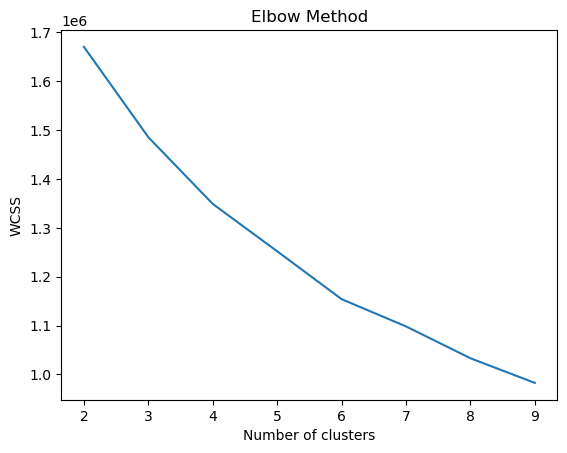

In [13]:
from sklearn.cluster import KMeans


wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, max_iter=50, n_init=5)
    kmeans.fit(X_resampled)
    wcss.append(kmeans.inertia_)

# Plot the results
plt.plot(range(2, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<font color='teal'>

according to the graph the best number of clusters is at 5

</font>

In [14]:
kmeans = KMeans(n_clusters=5, max_iter=300, n_init=10)
kmeans.fit(X_resampled)
labels = kmeans.labels_

In [15]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

homogeneity = homogeneity_score(y_resampled, labels)
completeness = completeness_score(y_resampled, labels)
v_measure = v_measure_score(y_resampled, labels)

print(f'Homogeneity: {homogeneity}')
print(f'Completeness: {completeness}')
print(f'V-Measure: {v_measure}')


Homogeneity: 0.24574505897343366
Completeness: 0.2647662529395445
V-Measure: 0.2549012996362141


<font color='teal'>

Homogeneity: Each cluster contains only members of a single class. <br>
Completeness: All members of a given class are assigned to the same cluster.<br>
V-Measure: Harmonic mean of homogeneity and completeness.

</font>

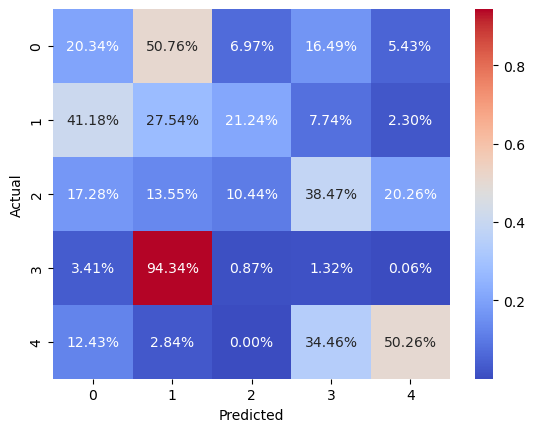

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_resampled, labels, normalize = 'true')

sns.heatmap(cm, annot = True, fmt = '.2%', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<font color='red'>

# 3. Hierarchical Clustering
</font>

<font color='red'>

## resampling
</font>

<font color='teal'>

To be able to draw the resulting dendogram, we use undersampling for this part.

</font>

In [17]:
y = df.iloc[:,-1]
X = df.iloc[:,:-1]

In [18]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_under, y_under = rus.fit_resample(X,y)

In [19]:
df_ru = pd.DataFrame(X_under) 

In [20]:
df_ru[188] = y_under

C:\Users\pc\AppData\Local\Temp\ipykernel_7212\1756550200.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ru[188] = y_under


In [21]:
df_ru.iloc[:,-1].value_counts()

188
0.0    641
1.0    641
2.0    641
3.0    641
4.0    641
Name: count, dtype: int64

<font color='red'>

## Agglomerative Hierarchical Clustering
</font>

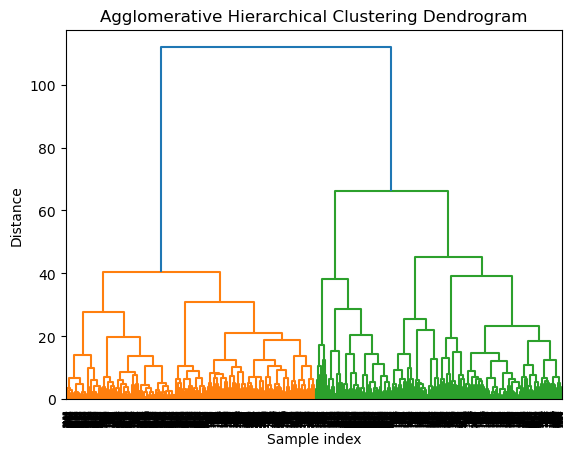

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(X_under, method='ward')


dendrogram(Z)
plt.title('Agglomerative Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

labels = fcluster(Z, 5, criterion='maxclust')

In [23]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

homogeneity = homogeneity_score(y_under, labels)
completeness = completeness_score(y_under, labels)
v_measure = v_measure_score(y_under, labels)

print(f'Homogeneity: {homogeneity}')
print(f'Completeness: {completeness}')
print(f'V-Measure: {v_measure}')


Homogeneity: 0.24346422787415056
Completeness: 0.2530631289573067
V-Measure: 0.24817089510707854


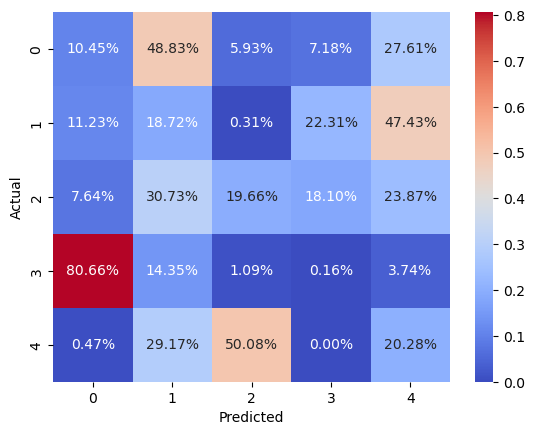

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_under+1, labels, normalize = 'true')

sns.heatmap(cm, annot = True, fmt = '.2%', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<font color='red'>

# 4. DBSCAN
</font>

<font color='teal'>

Due to hardware limitation, we chose a susbset of the oversampled dataset.

</font>

In [25]:
dbs = df_rs.groupby(df_rs.columns[-1]).apply(lambda x: x.sample(n=5000)).reset_index(drop=True)

y_ch = dbs.iloc[:,-1]
X_ch = dbs.iloc[:,:-1]

C:\Users\pc\AppData\Local\Temp\ipykernel_7212\289940666.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dbs = df_rs.groupby(df_rs.columns[-1]).apply(lambda x: x.sample(n=5000)).reset_index(drop=True)


In [26]:
from sklearn.cluster import DBSCAN

def apply_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = list(labels).count(-1)
    
    return n_clusters, n_outliers

eps_values = [1.15, 1.2, 1.25, 1.3,1.35]
min_samples_values = [20,50, 100, 200, 300]

for eps in eps_values:
    for min_samples in min_samples_values:
        n_clusters, n_outliers = apply_dbscan(X_ch, eps, min_samples)
        print(f'eps={eps}, min_samples={min_samples} -> Clusters: {n_clusters}, Outliers: {n_outliers}')



eps=1.15, min_samples=20 -> Clusters: 16, Outliers: 2577
eps=1.15, min_samples=50 -> Clusters: 13, Outliers: 4992
eps=1.15, min_samples=100 -> Clusters: 6, Outliers: 7853
eps=1.15, min_samples=200 -> Clusters: 6, Outliers: 10417
eps=1.15, min_samples=300 -> Clusters: 5, Outliers: 13829
eps=1.2, min_samples=20 -> Clusters: 18, Outliers: 2129
eps=1.2, min_samples=50 -> Clusters: 12, Outliers: 4157
eps=1.2, min_samples=100 -> Clusters: 5, Outliers: 6829
eps=1.2, min_samples=200 -> Clusters: 3, Outliers: 9193
eps=1.2, min_samples=300 -> Clusters: 5, Outliers: 12226
eps=1.25, min_samples=20 -> Clusters: 13, Outliers: 1848
eps=1.25, min_samples=50 -> Clusters: 12, Outliers: 3493
eps=1.25, min_samples=100 -> Clusters: 5, Outliers: 5871
eps=1.25, min_samples=200 -> Clusters: 3, Outliers: 8482
eps=1.25, min_samples=300 -> Clusters: 3, Outliers: 10450
eps=1.3, min_samples=20 -> Clusters: 10, Outliers: 1578
eps=1.3, min_samples=50 -> Clusters: 8, Outliers: 2936
eps=1.3, min_samples=100 -> Cluster

<font color='red'>

# 5. PCA for Dimensionality Reduction
</font>

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
principal_components = pca.fit_transform(X_resampled)

pca_df = pd.DataFrame(principal_components)


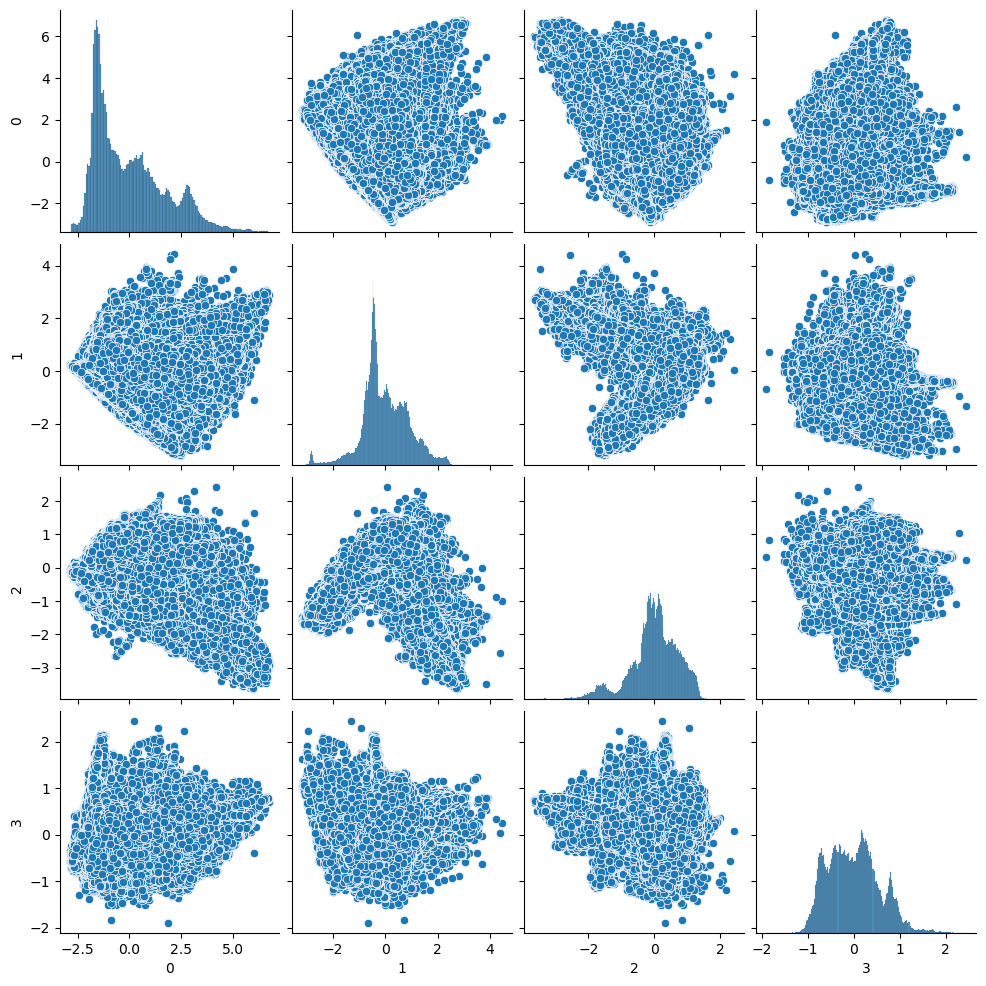

In [28]:
sns.pairplot(pca_df)
plt.show()

In [29]:
X_resampled.shape, pca_df.shape

((362355, 187), (362355, 4))

In [30]:
X_resampled = pca_df
df_rs = X_resampled
df_rs[188] = y_resampled

<font color='red'>

## K-means Clustering with PCA
</font>

In [31]:
dbs = df_rs.groupby(df_rs.columns[-1]).apply(lambda x: x.sample(n=5000)).reset_index(drop=True)

y_ch = dbs.iloc[:,-1]
X_ch = dbs.iloc[:,:-1]

C:\Users\pc\AppData\Local\Temp\ipykernel_7212\289940666.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dbs = df_rs.groupby(df_rs.columns[-1]).apply(lambda x: x.sample(n=5000)).reset_index(drop=True)


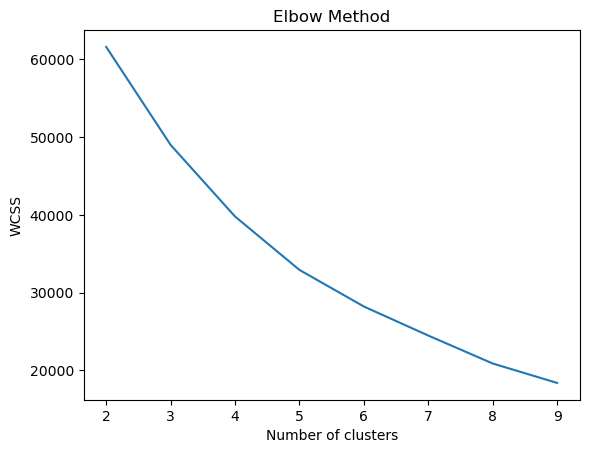

In [32]:
from sklearn.cluster import KMeans

wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, max_iter=50, n_init=5)
    kmeans.fit(X_ch)
    wcss.append(kmeans.inertia_)

# Plot the results
plt.plot(range(2, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<font color='teal'>

according to the graph the best number of clusters is at 5

</font>

In [33]:
kmeans = KMeans(n_clusters=5, max_iter=300, n_init=10)
kmeans.fit(X_ch)
labels = kmeans.labels_

In [34]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

homogeneity = homogeneity_score(y_ch, labels)
completeness = completeness_score(y_ch, labels)
v_measure = v_measure_score(y_ch, labels)

print(f'Homogeneity: {homogeneity}')
print(f'Completeness: {completeness}')
print(f'V-Measure: {v_measure}')


Homogeneity: 0.24477841325607902
Completeness: 0.2570247130839625
V-Measure: 0.25075213020358206


<font color='teal'>

Homogeneity: Each cluster contains only members of a single class. <br>
Completeness: All members of a given class are assigned to the same cluster.<br>
V-Measure: Harmonic mean of homogeneity and completeness.

</font>

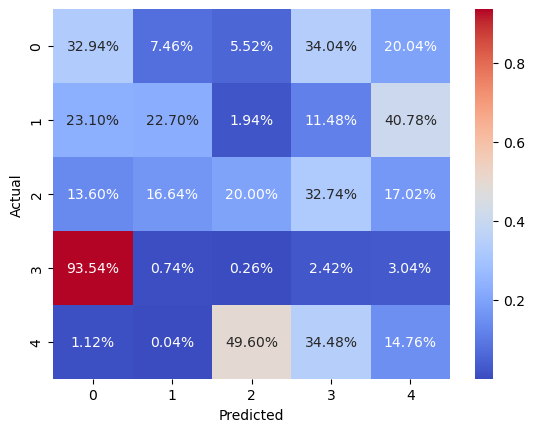

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_ch, labels, normalize = 'true')

sns.heatmap(cm, annot = True, fmt = '.2%', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

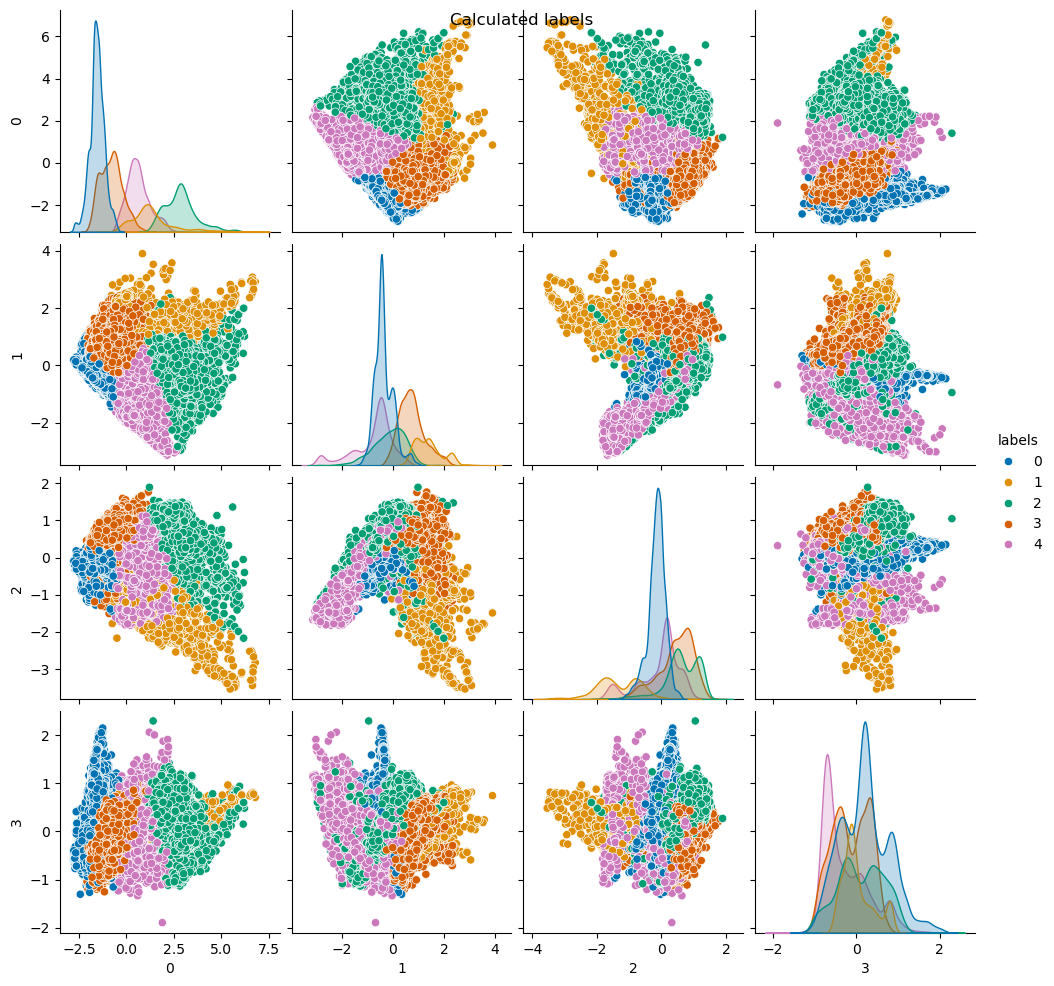

In [36]:
df_4plt = X_ch
df_4plt['labels'] = labels
sns.pairplot(X_ch,hue = 'labels',palette = 'colorblind')
plt.suptitle('Calculated labels')
plt.show()

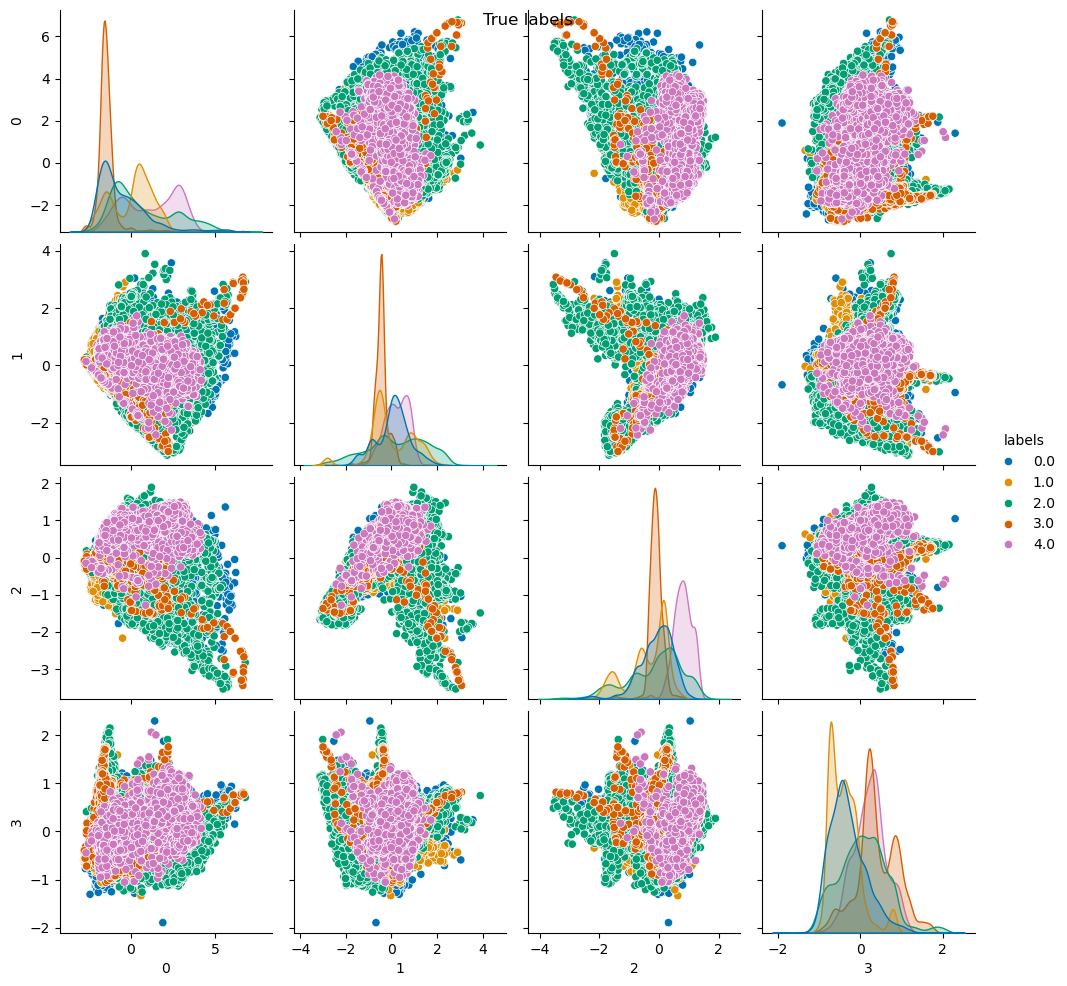

In [37]:
df_4plt = X_ch
df_4plt['labels'] = y_ch
sns.pairplot(X_ch,hue = 'labels',palette = 'colorblind')
plt.suptitle('True labels')
plt.show()

<font color='red'>

## Hierarchical Clustering with PCA
</font>

<font color='red'>

### resampling
</font>

<font color='teal'>

To be able to draw the resulting dendogram, we use undersampling for this part.

</font>

In [38]:
dbs = df_rs.groupby(df_rs.columns[-1]).apply(lambda x: x.sample(n=500)).reset_index(drop=True)

y_ch = dbs.iloc[:,-1]
X_ch = dbs.iloc[:,:-1]

C:\Users\pc\AppData\Local\Temp\ipykernel_7212\2965210770.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dbs = df_rs.groupby(df_rs.columns[-1]).apply(lambda x: x.sample(n=500)).reset_index(drop=True)


<font color='red'>

### Agglomerative Hierarchical Clustering
</font>

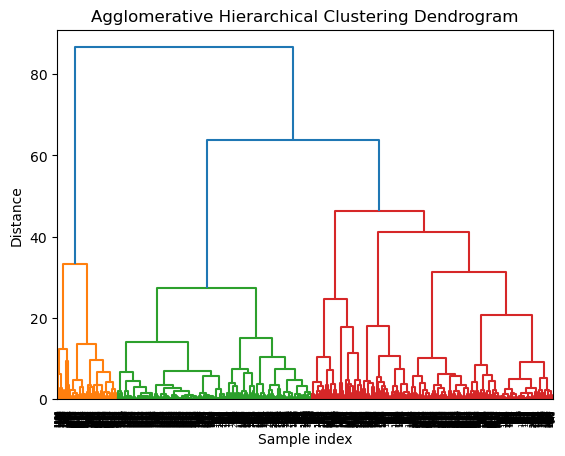

In [39]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


# Perform agglomerative hierarchical clustering
Z = linkage(X_ch, method='ward')


dendrogram(Z)
plt.title('Agglomerative Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

labels = fcluster(Z, 5, criterion='maxclust')

In [40]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

homogeneity = homogeneity_score(y_ch, labels)
completeness = completeness_score(y_ch, labels)
v_measure = v_measure_score(y_ch, labels)

print(f'Homogeneity: {homogeneity}')
print(f'Completeness: {completeness}')
print(f'V-Measure: {v_measure}')


Homogeneity: 0.21709372200100546
Completeness: 0.24240188973906235
V-Measure: 0.22905084235406897


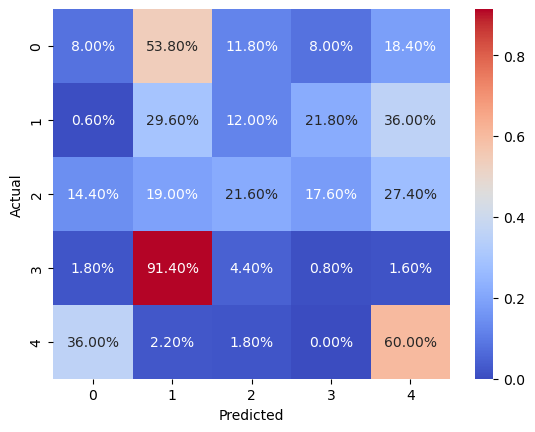

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_ch+1, labels, normalize = 'true')

sns.heatmap(cm, annot = True, fmt = '.2%', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
df_4plt

0         1         2         3  labels
0     -1.341294  0.395407  0.541967 -0.823080     0.0
1      1.998628 -1.360168  0.131970  0.021053     0.0
2      0.464566  0.598041 -0.437771 -0.128561     0.0
3      1.279659  0.720807 -0.045215 -0.009361     0.0
4     -0.532093 -0.757688 -0.348180 -0.661167     0.0
...         ...       ...       ...       ...     ...
24995 -0.401703  0.760249  0.949992  0.331094     4.0
24996  1.618405 -0.273669  0.995586  0.347780     4.0
24997  2.574008  0.285748  1.374856  0.420220     4.0
24998 -0.655058  0.987914  0.877718  0.427566     4.0
24999 -1.540100  0.626929  0.596364 -0.572737     4.0

[25000 rows x 5 columns]

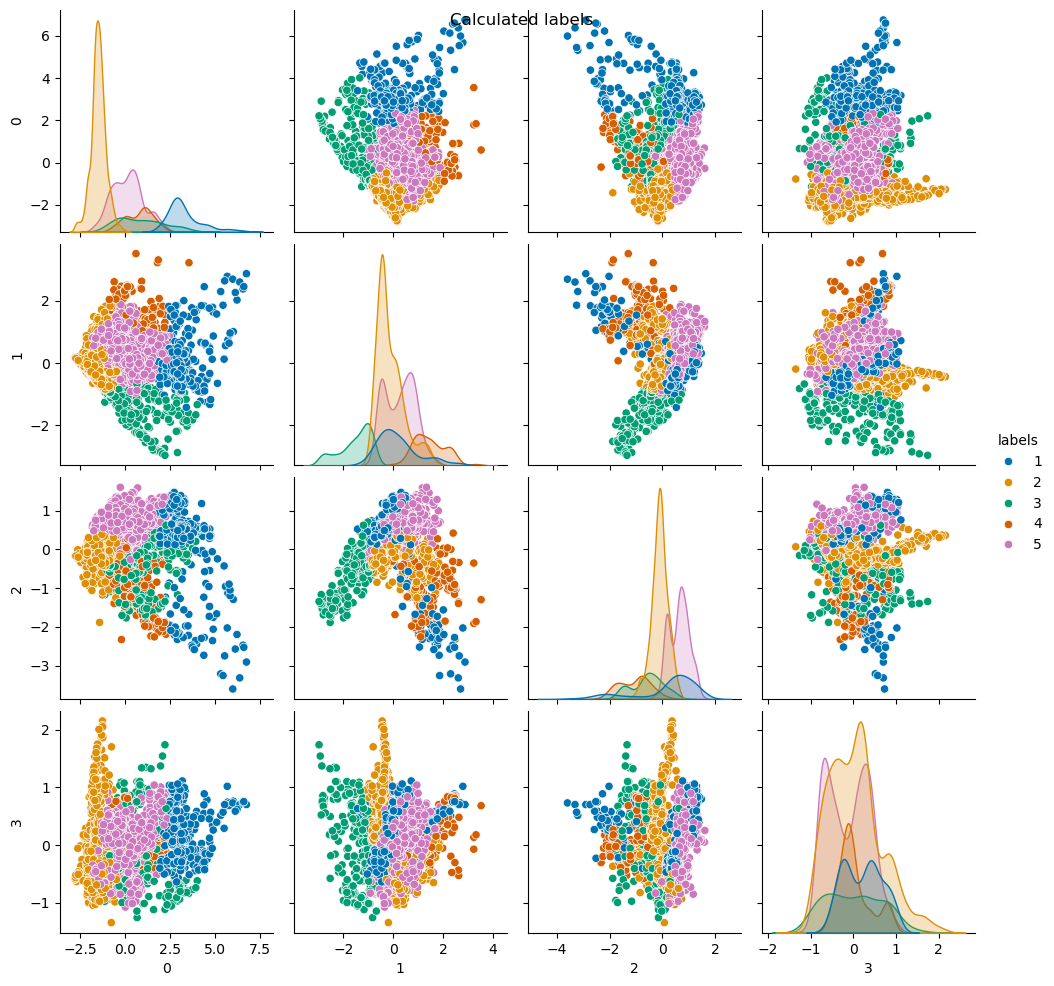

In [43]:
df_4plt = X_ch
df_4plt['labels'] = labels
sns.pairplot(X_ch,hue = 'labels',palette = 'colorblind')
plt.suptitle('Calculated labels')
plt.show()

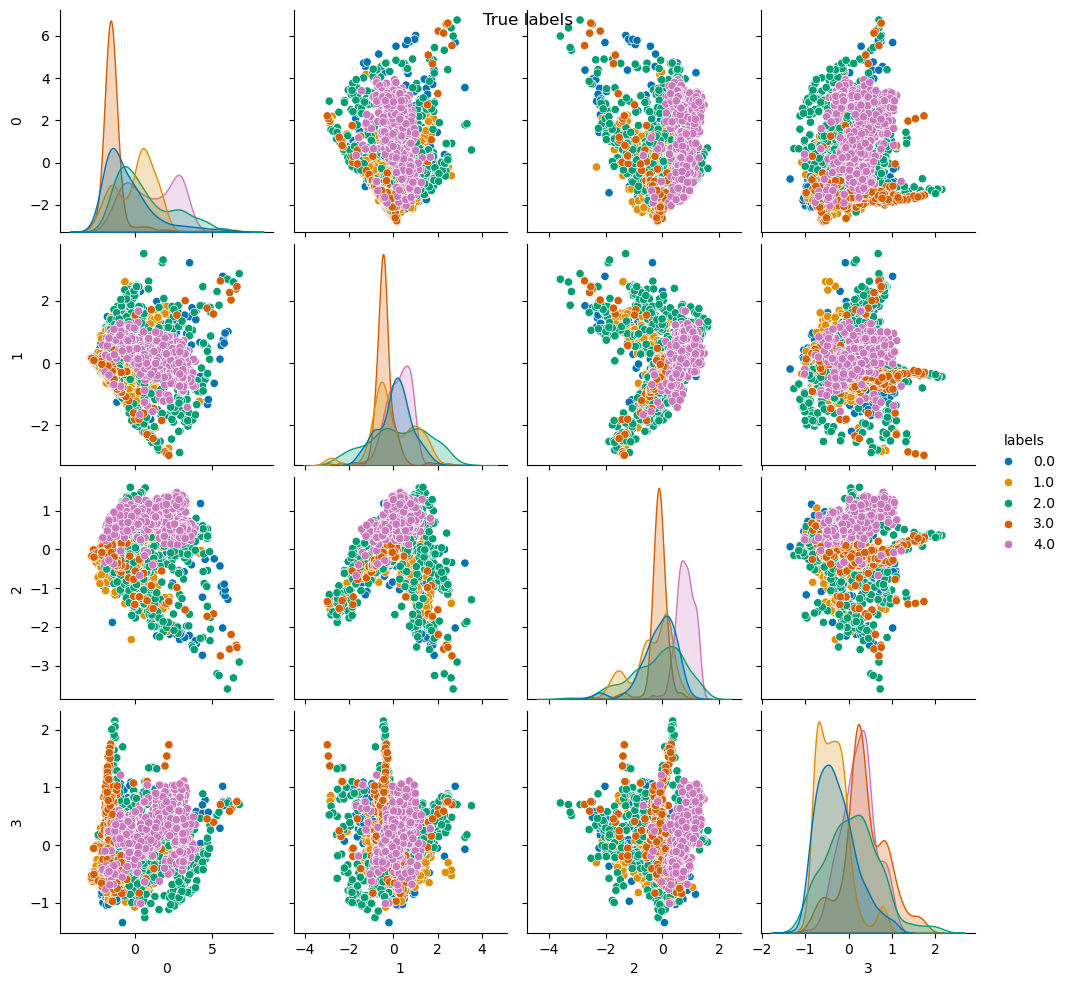

In [44]:
# true labels
df_4plt = X_ch
df_4plt['labels'] = y_ch
sns.pairplot(X_ch,hue = 'labels',palette = 'colorblind')
plt.suptitle('True labels')
plt.show()

<font color='red'>

## DBSCAN with PCA
</font>

In [45]:
dbs = df_rs.groupby(df_rs.columns[-1]).apply(lambda x: x.sample(n=1000)).reset_index(drop=True)

y_ch = dbs.iloc[:,-1]
X_ch = dbs.iloc[:,:-1]

C:\Users\pc\AppData\Local\Temp\ipykernel_7212\2136776398.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dbs = df_rs.groupby(df_rs.columns[-1]).apply(lambda x: x.sample(n=1000)).reset_index(drop=True)


In [46]:
from sklearn.cluster import DBSCAN

def apply_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = list(labels).count(-1)
    
    return n_clusters, n_outliers

eps_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
min_samples_values = [20,50, 100, 200, 300, 500]

for eps in eps_values:
    for min_samples in min_samples_values:
        n_clusters, n_outliers = apply_dbscan(X_ch, eps, min_samples)
        print(f'eps={eps}, min_samples={min_samples} -> Clusters: {n_clusters}, Outliers: {n_outliers}')



eps=0.3, min_samples=20 -> Clusters: 14, Outliers: 1388
eps=0.3, min_samples=50 -> Clusters: 5, Outliers: 2773
eps=0.3, min_samples=100 -> Clusters: 2, Outliers: 3702
eps=0.3, min_samples=200 -> Clusters: 1, Outliers: 4418
eps=0.3, min_samples=300 -> Clusters: 1, Outliers: 4664
eps=0.3, min_samples=500 -> Clusters: 0, Outliers: 5000
eps=0.4, min_samples=20 -> Clusters: 5, Outliers: 597
eps=0.4, min_samples=50 -> Clusters: 9, Outliers: 1669
eps=0.4, min_samples=100 -> Clusters: 3, Outliers: 2630
eps=0.4, min_samples=200 -> Clusters: 2, Outliers: 3554
eps=0.4, min_samples=300 -> Clusters: 1, Outliers: 4171
eps=0.4, min_samples=500 -> Clusters: 0, Outliers: 5000
eps=0.5, min_samples=20 -> Clusters: 2, Outliers: 325
eps=0.5, min_samples=50 -> Clusters: 5, Outliers: 717
eps=0.5, min_samples=100 -> Clusters: 4, Outliers: 2016
eps=0.5, min_samples=200 -> Clusters: 3, Outliers: 2586
eps=0.5, min_samples=300 -> Clusters: 2, Outliers: 3448
eps=0.5, min_samples=500 -> Clusters: 1, Outliers: 4089


<font color='red'>

# 6. Cluster Evaluation and Comparison
</font>

In [47]:
dbs = df_rs.groupby(df_rs.columns[-1]).apply(lambda x: x.sample(n=5000)).reset_index(drop=True)

y_ch = dbs.iloc[:,-1]
X_ch = dbs.iloc[:,:-1]

C:\Users\pc\AppData\Local\Temp\ipykernel_7212\289940666.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dbs = df_rs.groupby(df_rs.columns[-1]).apply(lambda x: x.sample(n=5000)).reset_index(drop=True)


In [48]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score

In [49]:
def calculate_wcss(X, labels):
    wcss = 0
    for label in np.unique(labels):
        cluster_points = X[labels == label]
        centroid = cluster_points.mean(axis=0)
        wcss += ((cluster_points - centroid) ** 2).sum()
    return wcss

In [50]:
# KMeans
kmeans = KMeans(n_clusters=5)
kmeans_labels = kmeans.fit_predict(X_ch)

# Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=5)
agglomerative_labels = agglomerative.fit_predict(X_ch)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=300)
dbscan_labels = dbscan.fit_predict(X_ch)

In [51]:
# Silhouette Score
kmeans_silhouette = silhouette_score(X_ch, kmeans_labels)
agglomerative_silhouette = silhouette_score(X_ch, agglomerative_labels)
dbscan_silhouette = silhouette_score(X_ch, dbscan_labels)

# Davies-Bouldin Index
kmeans_davies_bouldin = davies_bouldin_score(X_ch, kmeans_labels)
agglomerative_davies_bouldin = davies_bouldin_score(X_ch, agglomerative_labels)
dbscan_davies_bouldin = davies_bouldin_score(X_ch, dbscan_labels)

# Within-Cluster Sum of Squares (WCSS)
kmeans_wcss = calculate_wcss(X_ch, kmeans_labels)
agglomerative_wcss = calculate_wcss(X_ch, agglomerative_labels)
dbscan_wcss = calculate_wcss(X_ch, dbscan_labels)

# Adjusted Rand Index (ARI)
kmeans_ari = adjusted_rand_score(y_ch, kmeans_labels)
agglomerative_ari = adjusted_rand_score(y_ch, agglomerative_labels)
dbscan_ari = adjusted_rand_score(y_ch, dbscan_labels)

# Normalized Mutual Information (NMI)
kmeans_nmi = normalized_mutual_info_score(y_ch, kmeans_labels)
agglomerative_nmi = normalized_mutual_info_score(y_ch, agglomerative_labels)
dbscan_nmi = normalized_mutual_info_score(y_ch, dbscan_labels)



In [52]:
results = pd.DataFrame({
    'Algorithm': ['KMeans', 'Agglomerative', 'DBSCAN'],
    'Silhouette Score': [kmeans_silhouette, agglomerative_silhouette, dbscan_silhouette],
    'Davies-Bouldin Index': [kmeans_davies_bouldin, agglomerative_davies_bouldin, dbscan_davies_bouldin],
    'WCSS': [kmeans_wcss, agglomerative_wcss, dbscan_wcss],
    'Adjusted Rand Index (ARI)': [kmeans_ari, agglomerative_ari, dbscan_ari],
    'Normalized Mutual Information (NMI)': [kmeans_nmi, agglomerative_nmi, dbscan_nmi]
})

results


Algorithm  Silhouette Score  Davies-Bouldin Index  \
0         KMeans          0.352268              1.032623   
1  Agglomerative          0.340511              1.043416   
2         DBSCAN          0.185354              1.795406   

                                                WCSS  \
0  0    11476.502637
1     8162.698107
2     6722...   
1  0    10914.525627
1    11577.740607
2     6642...   
2  0    30254.032665
1    16184.137243
2     7300...   

   Adjusted Rand Index (ARI)  Normalized Mutual Information (NMI)  
0                   0.212721                             0.251288  
1                   0.203596                             0.274310  
2                   0.070730                             0.206997

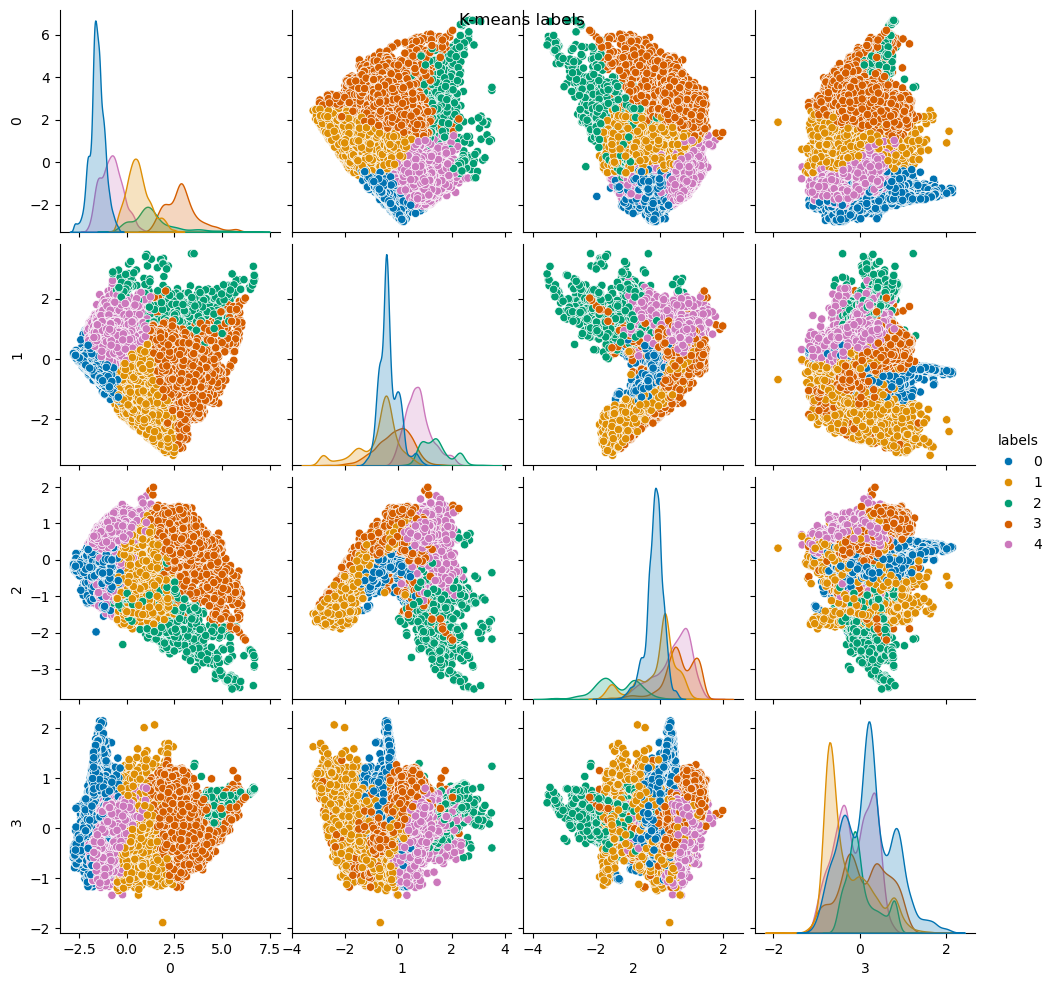

In [53]:
df_4plt = X_ch
df_4plt['labels'] = kmeans_labels
sns.pairplot(X_ch,hue = 'labels',palette = 'colorblind')
plt.suptitle('K-means labels')
plt.show()

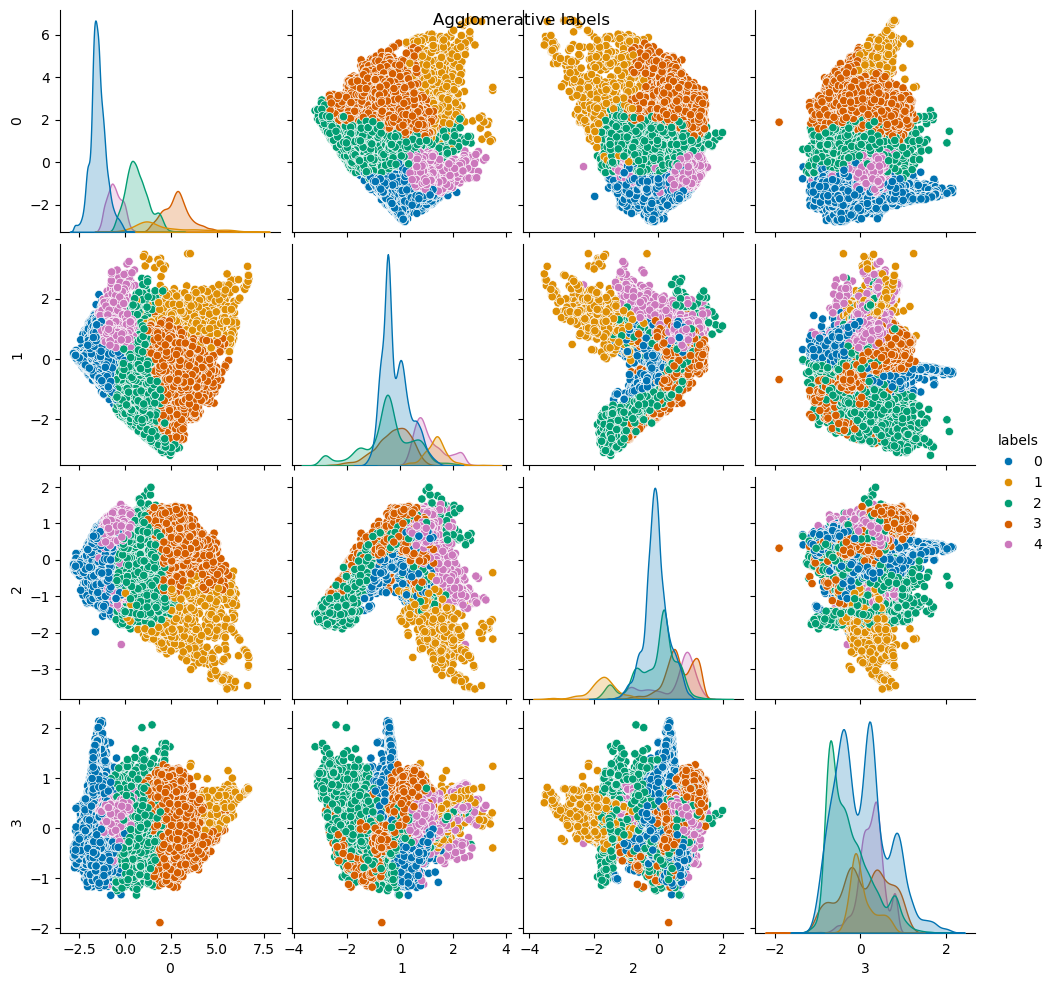

In [54]:
df_4plt = X_ch
df_4plt['labels'] = agglomerative_labels
sns.pairplot(X_ch,hue = 'labels',palette = 'colorblind')
plt.suptitle('Agglomerative labels')
plt.show()

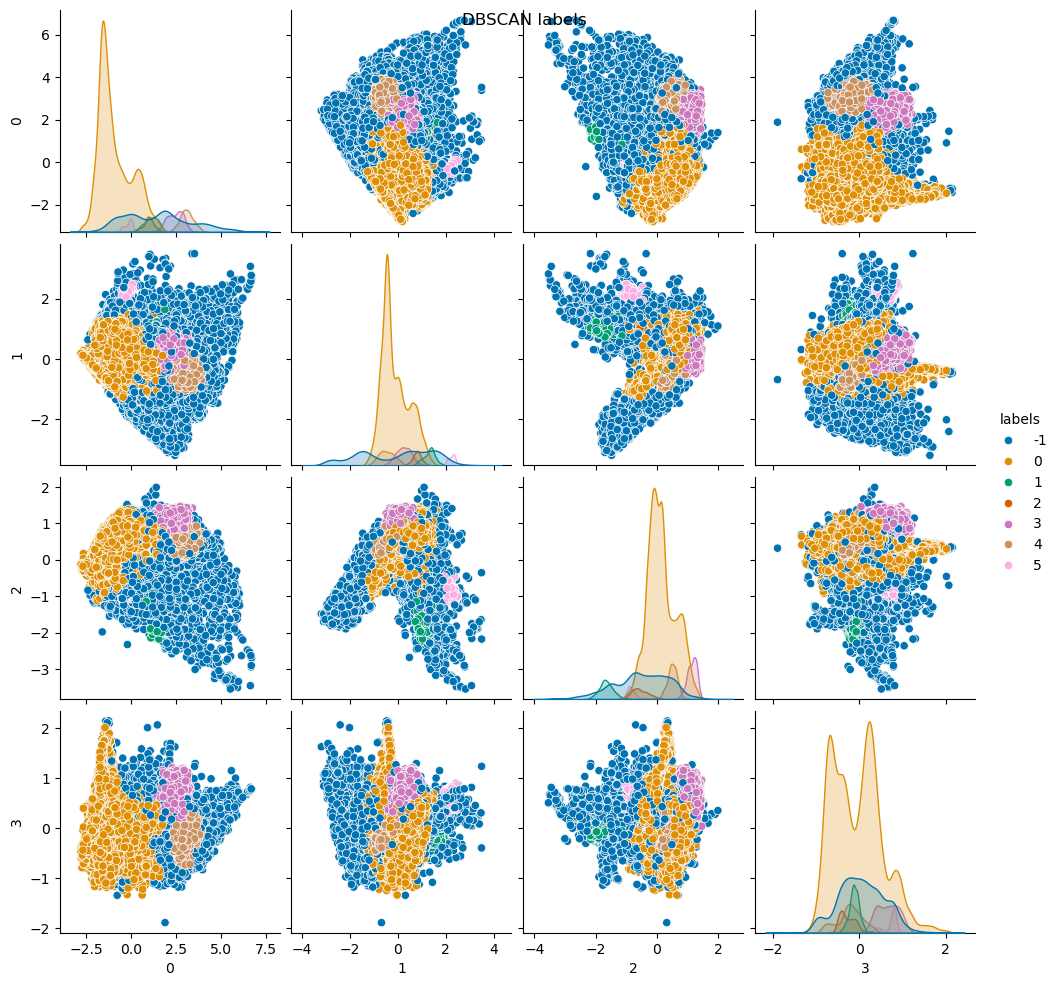

In [55]:
df_4plt = X_ch
df_4plt['labels'] = dbscan_labels
sns.pairplot(X_ch,hue = 'labels',palette = 'colorblind')
plt.suptitle('DBSCAN labels')
plt.show()

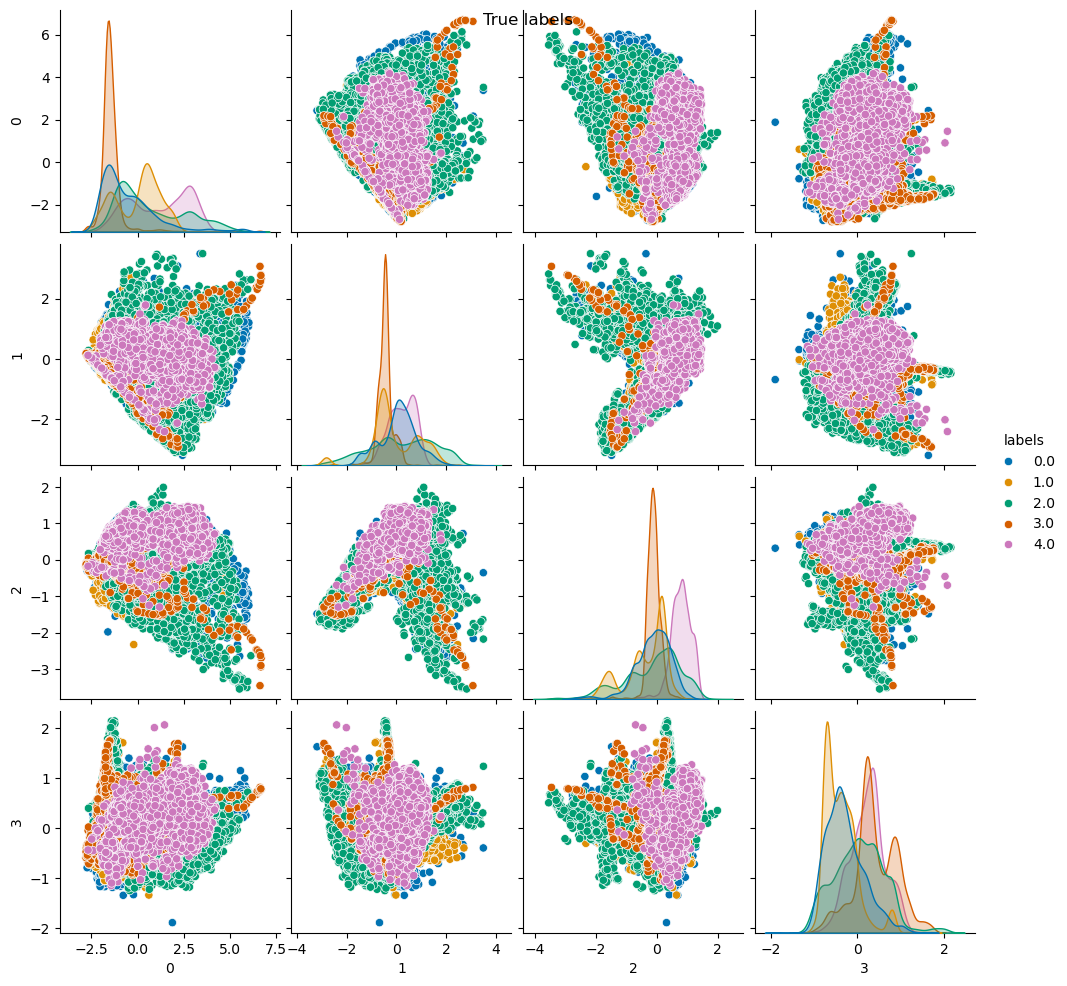

In [56]:
df_4plt = X_ch
df_4plt['labels'] = y_ch
sns.pairplot(X_ch,hue = 'labels',palette = 'colorblind')
plt.suptitle('True labels')
plt.show()